In [14]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

import gala as ga

import sys
sys.path.append("../src/helpers")
import kicks as kk

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [3]:
galcen_frame = coord.Galactocentric()

In [4]:
sun_w0 = gd.PhaseSpacePosition(
    pos=[-8.2, 0, 0.02] * u.kpc,
    vel=galcen_frame.galcen_v_sun
)

In [34]:
c = coord.SkyCoord(ra="17:51:40.2082", dec="-29:53:26.502", unit=(u.hourangle, u.degree))
cosdec = np.cos(c.dec) 

w0s = []

for rv in np.zeros(5):
    c = coord.SkyCoord(
        ra="17:51:40.2082",
        dec="-29:53:26.502",
        unit=(u.hourangle, u.degree),
        distance=1.58*u.kpc,
        pm_ra_cosdec=-4.36*u.mas/u.yr,# * cosdec,
        pm_dec=3.06*u.mas/u.yr,
        radial_velocity=rv*u.km/u.s
    )

    w0 = gd.PhaseSpacePosition(c.transform_to(galcen_frame).data)
    w0s.append(w0)
    
w0s = gd.combine(w0s)

In [35]:
pot = gp.MilkyWayPotential()
orbits = pot.integrate_orbit(w0s, dt=4*u.Gyr / 4000, n_steps=4000)
sun_orbit = pot.integrate_orbit(sun_w0, t=orbits.t)

In [83]:
no_kicks = kk.integrate_orbits_with_kicks(w0s, dt=4*u.Gyr / 4000, n_steps=4000)

In [91]:
# kicks = [(45 * u.km / u.s, 0 * u.deg, -90 * u.deg)]
kicks = None
kick_times = [0.5 * u.Gyr]
with_kicks_265 = kk.integrate_orbits_with_kicks(w0s, kicks=kicks, kick_times=kick_times,
                                               dt=4*u.Gyr / 4000, n_steps=4000,
                                               same_angle=False, ret_kicks=True,
                                               maxwell_sigma=265 * u.km/u.s)

with_kicks_30 = kk.integrate_orbits_with_kicks(w0s, kicks=kicks, kick_times=kick_times,
                                               dt=4*u.Gyr / 4000, n_steps=4000,
                                               same_angle=False, ret_kicks=True,
                                               maxwell_sigma=30 * u.km/u.s)

[336.80799979 264.22813071 626.24198505 359.52634237 241.34430323] km / s
[40.77560519 42.44413362 38.39331187 69.93205484 39.9195898 ] km / s


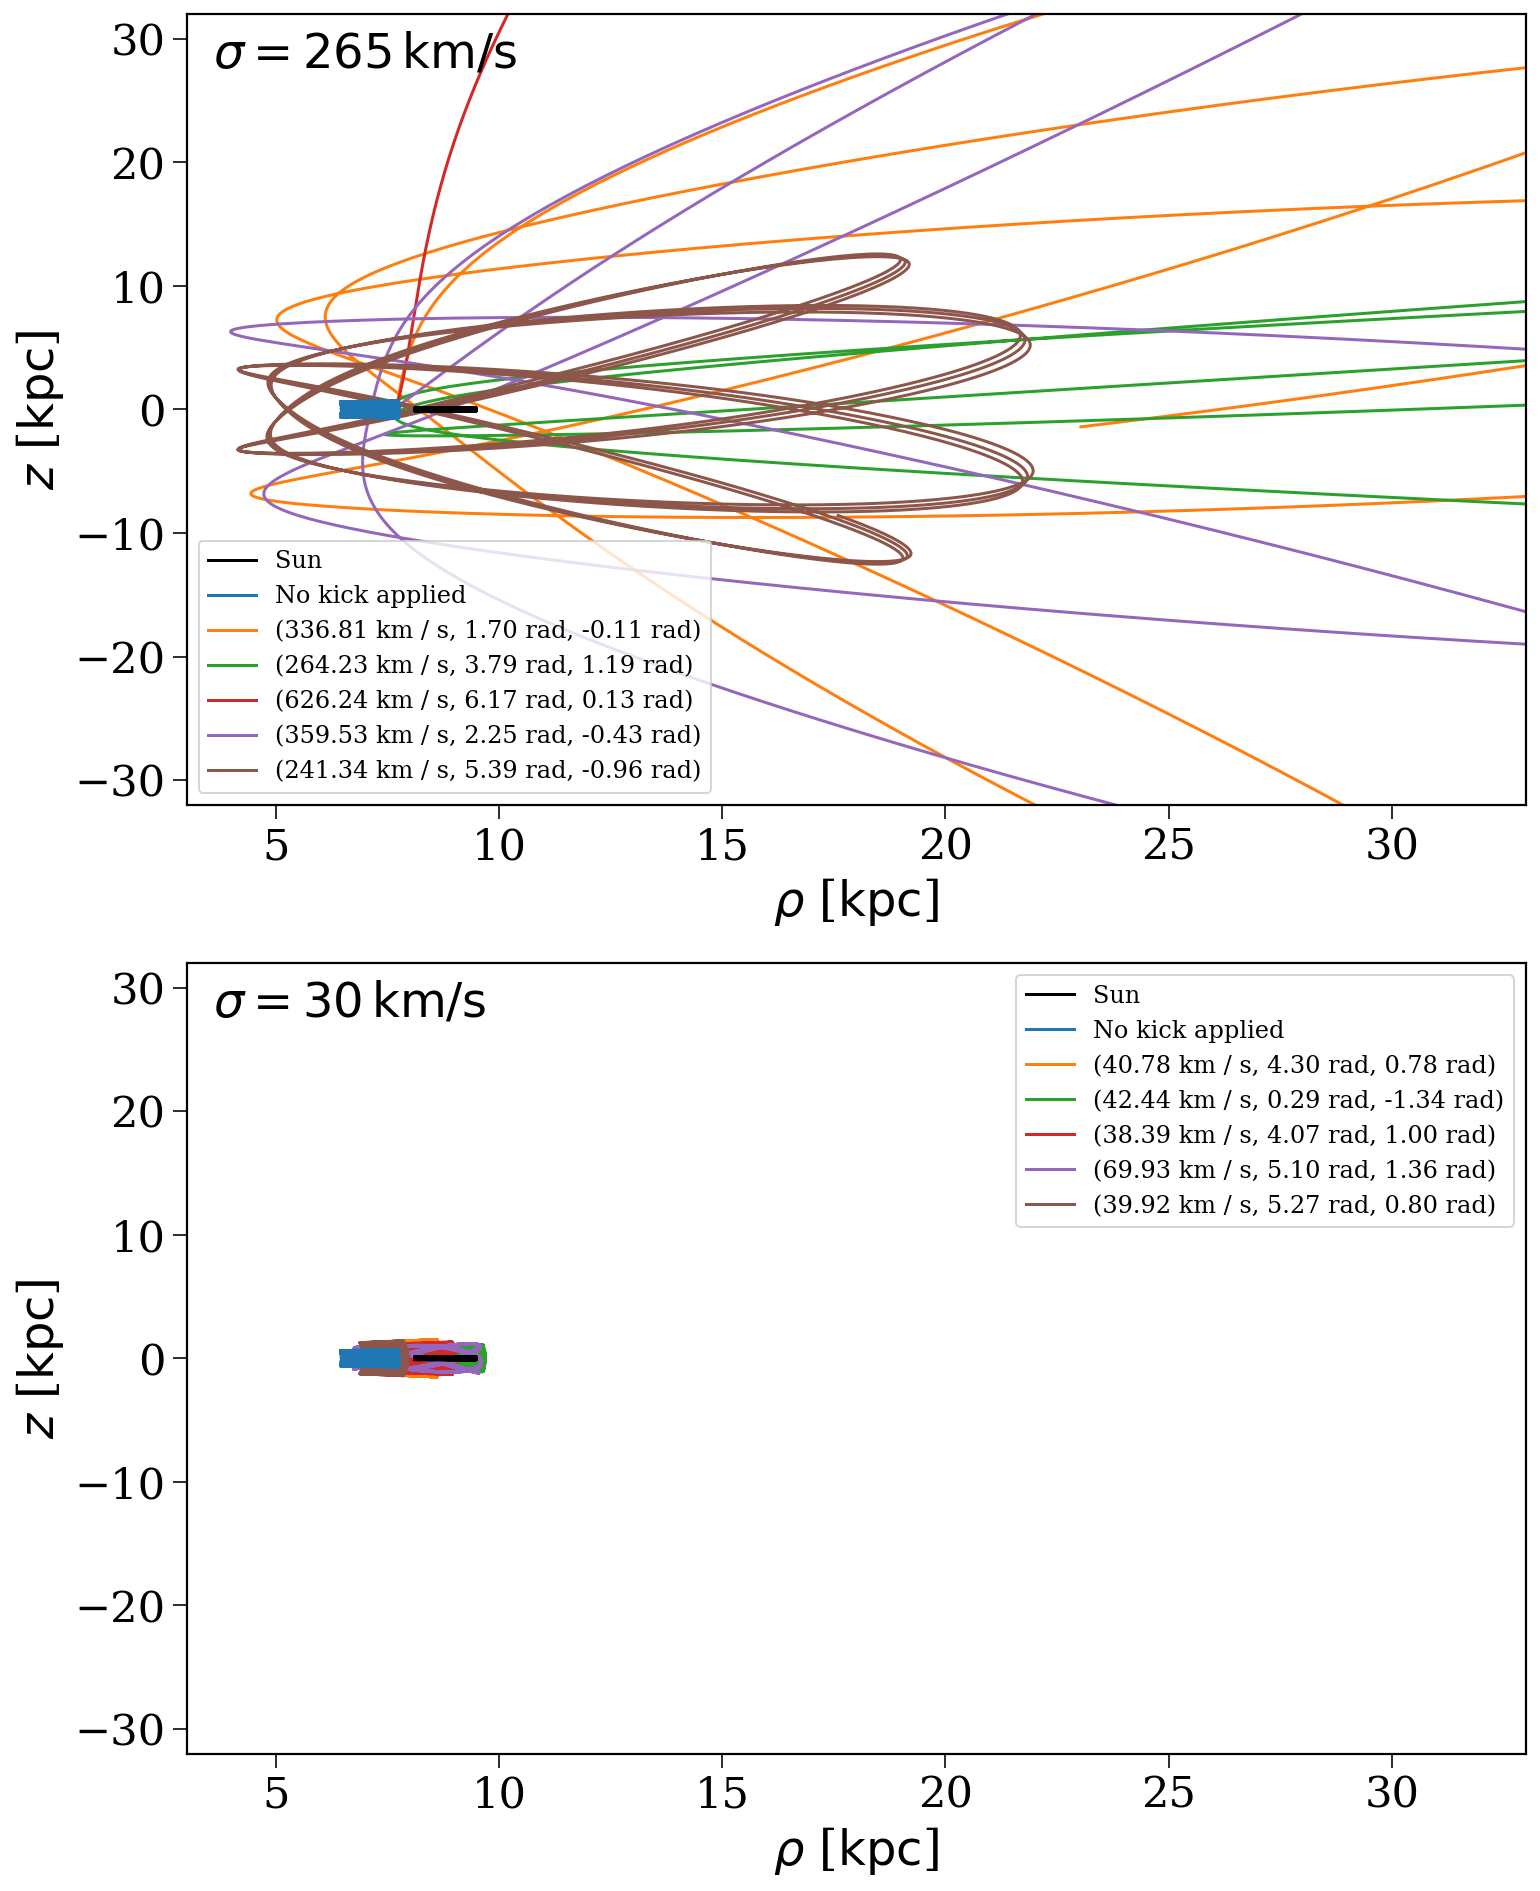

In [92]:
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

ax = axes[0]

# plot the sun
_ = sun_orbit.cylindrical.plot(['rho', 'z'], axes=[ax], color='black', zorder=100, label="Sun")

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# plot the orbits with kicks
_ = no_kicks[:, 0].cylindrical.plot(['rho', 'z'], axes=[ax], label=r"No kick applied", zorder=100)

with_kicks, kicks = with_kicks_265
for i in range(5):
    with_kicks[:, i].cylindrical.plot(['rho', 'z'], axes=[ax], label="({:1.2f}, {:1.2f}, {:1.2f})".format(kicks[i].magnitude, kicks[i].phi, kicks[i].theta))
    
# _ = 

ax.legend(fontsize=0.5*fs)

ax.set_xlim(min(ax.get_xlim()[0], xlim[0]), max(ax.get_xlim()[1], xlim[1]))
ax.set_ylim(min(ax.get_ylim()[0], ylim[0]), max(ax.get_ylim()[1], ylim[1]))

ax.set_xlim(3, 33)
ax.set_ylim(-32, 32)

ax.annotate(r"$\sigma = 265 \, {\rm km / s}$", xy=(0.02, 0.98), xycoords="axes fraction", va="top", fontsize=fs)

ax = axes[1]

# plot the sun
_ = sun_orbit.cylindrical.plot(['rho', 'z'], axes=[ax], color='black', zorder=100, label="Sun")

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# plot the orbits with kicks
_ = no_kicks[:, 0].cylindrical.plot(['rho', 'z'], axes=[ax], label=r"No kick applied", zorder=100)

with_kicks, kicks = with_kicks_30
for i in range(5):
    with_kicks[:, i].cylindrical.plot(['rho', 'z'], axes=[ax], label="({:1.2f}, {:1.2f}, {:1.2f})".format(kicks[i].magnitude, kicks[i].phi, kicks[i].theta))
    
# _ = 

ax.legend(fontsize=0.5*fs)

ax.set_xlim(min(ax.get_xlim()[0], xlim[0]), max(ax.get_xlim()[1], xlim[1]))
ax.set_ylim(min(ax.get_ylim()[0], ylim[0]), max(ax.get_ylim()[1], ylim[1]))

ax.set_xlim(3, 33)
ax.set_ylim(-32, 32)

ax.annotate(r"$\sigma = 30 \, {\rm km / s}$", xy=(0.02, 0.98), xycoords="axes fraction", va="top", fontsize=fs)

plt.show()